# Monte-Carlo method

## Finding distributions and statistical properties using MC

As we see in previous lecture, we can  find estimations for mean and (biased) variance of a black-box function $f$ using a huge number of implementations of input variable $X=\{x_1,\,x_2,\,\ldots,\,x_N\}$

$$
\mathbb E f \approx \overline f=\frac1N\sum_{i=1}^Nf(x_i)
$$
$$
\text{Var }f \approx \frac1N\sum_{i=1}^N\bigl(f(x_i)-\overline f\bigr)^2
$$

We can fined an approximate distribution of $f$ by a such type of simultaion.

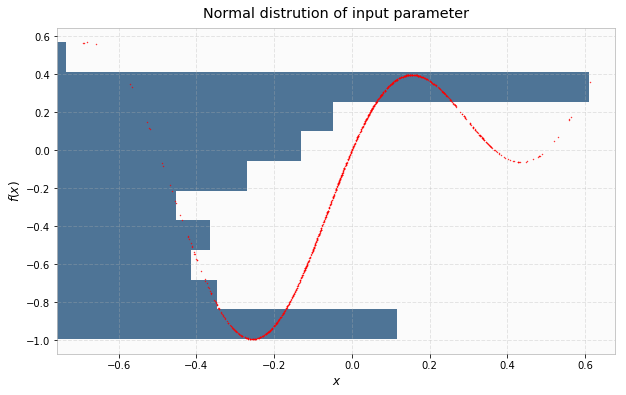

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def complex_func(x):
    return np.sin(2.0*x*np.pi)*np.cos(0.75*(x+0.3)*np.pi)

x = np.random.randn(int(1e3))/5.0
y = complex_func(x)

fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(1,1,1)
ax2 = fig.add_axes(ax1.get_position(), frameon=False)

ax1.hist(y, orientation='horizontal');
ax2.plot(x, y, 'r.', ms=0.8);
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
ax1.set_xticks([])
ax1.set_yticks([])
plt.title('Normal distrution of input parameter')
plt.show()

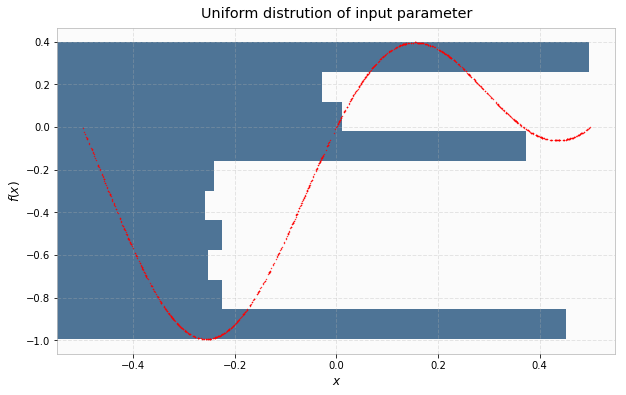

In [2]:
x = np.random.rand(int(1e3)) - 0.5
y = complex_func(x)

fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(1,1,1)
ax2 = fig.add_axes(ax1.get_position(), frameon=False)

ax1.hist(y, orientation='horizontal');
ax2.plot(x, y, 'r.', ms=0.8);
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
ax1.set_xticks([])
ax1.set_yticks([])
plt.title('Uniform distrution of input parameter')
plt.show()

## Integral estimation

Consider a simple example with function on 1 variable.

Let $0\leq f(x)\leq1$, $x\in[0,\,1]$ and we need to find
$$
I=\int_0^1f(x)\,dx.
$$

In the Monte-Carlo approach we sample a unit square $[0,\,1]\times [0,\,1]$ with quasi-random points sequence $\mathcal X = \{(x_i\,y_i)\}_1^N$.
Then the value of the integral $I$ is approximately equal to the ratio of the number of points <span class="mark">under</span> the graph of the function to the total number of points
$$
I\approx \frac1N \#\{(x_i,\,y_i)\in\mathcal X\colon f(x_i)>y_i\}
$$

I ≈ 0.6254, exact value = 0.636619772368


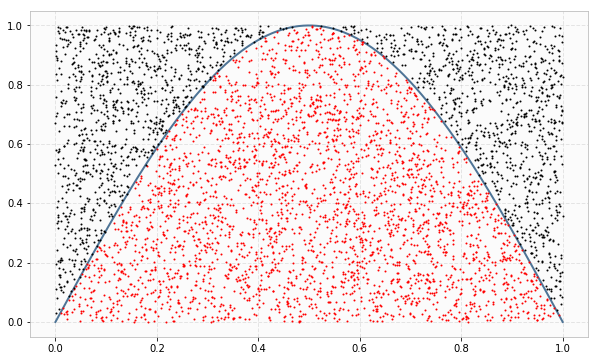

In [3]:
def f(x):
    return np.sin(x*np.pi)

f.exact_val = 1.0/np.pi*(-np.cos(np.pi) + np.cos(0))

x = np.linspace(0, 1, 2**10)
y = f(x)

plt.figure(figsize=(10,6))
plt.plot(x, y)

Xset = np.random.rand(5000, 2)
idx_under = f(Xset[:, 0]) > Xset[:, 1]
plt.plot(Xset[idx_under, 0], Xset[idx_under, 1], 'r.', Xset[~idx_under, 0], Xset[~idx_under, 1], 'k.', ms=2);
print("I ≈ {}, exact value = {}".format( float(len(Xset[idx_under]))/len(Xset), f.exact_val ) )

Let find how error depends on number of samples

In [4]:
def MC_error(f, Xset):
    idx_under = f(Xset[:, 0]) > Xset[:, 1]
    return np.abs(float(len(Xset[idx_under]))/len(Xset) - f.exact_val)

errors = np.array([(N**2, MC_error(f, np.random.rand(N**2, 2)) ) for N in range(3, 1000, 10)])


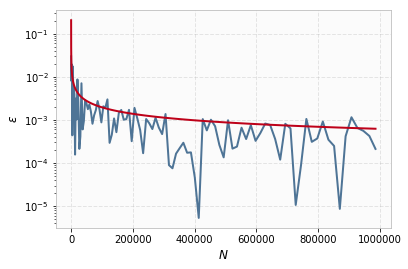

In [5]:
plt.plot(errors[:, 0], errors[:, 1], errors[:, 0], 2*0.31/errors[:, 0]**0.5)
plt.xlabel('$N$')
plt.ylabel('$\epsilon$')
plt.yscale('log')

Consider a Halton dequence which is low-discrepancy

In [6]:
from numba import jit

@jit
def halton(n, dim, start=0, bases=np.array([2,3])):
    """RETURNS Halton sequence"""

    r = np.zeros([n, dim])

    prime_inv_s = 1.0 / bases[:dim]

    for k, i in enumerate(range(start, start + n)):

        t = np.full(dim, i, dtype=int)

        prime_inv = np.copy(prime_inv_s)
        while 0 < np.sum(t):
            for j in range (0, dim):
                d = t[j] % bases[j]
                r[k, j] += d * prime_inv[j]
                prime_inv[j] /= bases[j]
                t[j] //= bases[j]

    return r

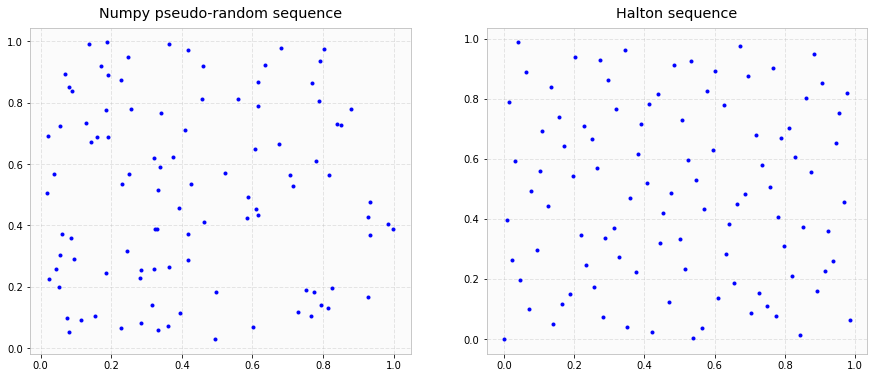

In [7]:
pnts_H = halton(100, 2)
pnts_r = np.random.rand(100, 2)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
ax1.plot(pnts_r[:, 0], pnts_r[:, 1], 'b.');
ax1.set_title('Numpy pseudo-random sequence');
ax2.plot(pnts_H[:, 0], pnts_H[:, 1], 'b.');
ax2.set_title('Halton sequence');

In [8]:
max_sqrt_N = 200
halton_seq = halton(max_sqrt_N**2, 2)
errors_Halton = np.array([(N**2, MC_error(f, halton_seq[:N**2]) ) for N in range(3, max_sqrt_N, 5)])


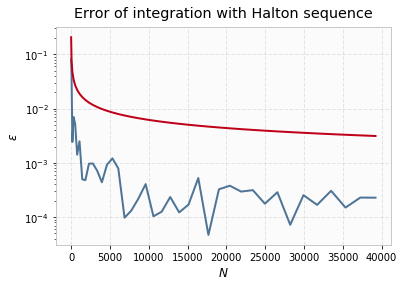

In [9]:
plt.plot(errors_Halton[:, 0], errors_Halton[:, 1], errors_Halton[:, 0], 2*0.31/errors_Halton[:, 0]**0.5)
plt.xlabel('$N$')
plt.ylabel('$\epsilon$')
plt.yscale('log')
plt.title("Error of integration with Halton sequence");

A greater contribution to the value of the integral is given by the points at which the function takes on a larger value.
The next idea is to use a distribution whose probability density is close to the value of the function.

Let the random variable $\xi$ have a distribution $\rho$. In this approach we approximately find the mean of the following value
$$
\mathbb E \frac f\rho=\int_0^1\frac{f(x)}{\rho(x)}\rho(x)\,dx\approx\frac1N\sum_{i=1}^N\frac{f(\xi_i)}{\rho(\xi_i)}
$$
where $\{\xi_1,\,\xi_2,\,\ldots,\,x_N\}$ are independent realisation of $\xi$.

First, we need to model a random value with the given distribution. For the simplicity, let this distributiion be piecewise constant.

In [10]:
@jit
def piecewise_distrib(f, m, N, interval=(0,1)):
    """RETURN N samples of the random variable
       INPUT  m sets the number of intervals
       Only for demonstrations purposes. Never use this func in real calculations!
    """
    intervls = np.linspace(interval[0], interval[1], m+1)
    intervls = np.vstack((intervls[:-1], intervls[1:])).T
    p = f(np.mean(intervls, axis=1))
    p /= p.sum()
    xi = np.empty(N)
    for i in range(N):
        cur_intrvl = intervls[np.random.choice(np.arange(len(intervls)), 1, p=p)][0]
        xi[i] = np.random.uniform(cur_intrvl[0], cur_intrvl[1])   
        
    return xi

def make_rho(f, m, interval=(0,1)):
    intervls = np.linspace(interval[0], interval[1], m+1)
    intervls = np.vstack((intervls[:-1], intervls[1:])).T
    p = f(np.mean(intervls, axis=1))
    p /= p.sum()
    ln = interval[1] - interval[0]
    
    def rho(x):
        if 0 >= x or x >= 1:
            return 0.0
        return p[int(np.floor(x*m))]*m/ln
    
    return np.vectorize(rho, signature="()->()")

# Compile it
piecewise_distrib(f, 3, 10);

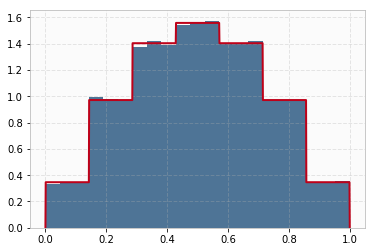

In [16]:
m = 7 # Number of intervals we divide to
xis = piecewise_distrib(f, m, 100000)
plt.hist(xis, bins=3*m, range=(0,1), density=True);
rho = make_rho(f,uu m)
x = np.linspace(0, 1, 2**10)
plt.plot(x, rho(x));

Now plot the error of the integral estimation with this approach

In [12]:
max_sqrt_N = 200
pd_seq = piecewise_distrib(f, m, max_sqrt_N**2)
errors_pd = np.array([(   N**2, np.abs(f.exact_val - np.mean(f(pd_seq[:N**2])/rho(pd_seq[:N**2])) )   ) for N in range(3, max_sqrt_N, 5)])


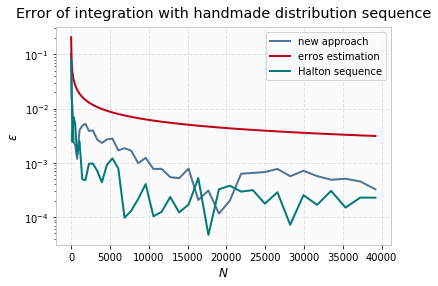

In [13]:
plt.plot(errors_pd[:, 0], errors_pd[:, 1], errors_pd[:, 0], 2*0.31/errors_pd[:, 0]**0.5, errors_Halton[:, 0], errors_Halton[:, 1])
plt.xlabel('$N$')
plt.ylabel('$\epsilon$')
plt.yscale('log')
plt.title("Error of integration with handmade distribution sequence");
plt.legend(['new approach', 'erros estimation', 'Halton sequence']);